In [1]:
# IMPORT REQUIRED LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from abess import LinearRegression as ABESS_LR # Adaptive BEst Subset Selection
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from models import PCR, SPCA_LR, SFS_LR, SFS_QR 

SEED = 9

In [2]:
# IMPORT PROCESSED DATA

abs_df = pd.read_csv("C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Final Data\\AvgAbs.csv", index_col=0)

wavelengths = abs_df.iloc[:, :-1].columns

### Removing Outliers - Visual Inspection (EDA)

Scatter plot of Absorbance Value at 485 nm v/s Brix Values - Outlier has lowest Brix value.

In [ ]:
abs_df = abs_df.iloc[1:, :]

## Latent Variable Models

### PLSR

In [27]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, X.shape[1]+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, X.shape[1]+1):

    regressor = PLSRegression(n_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

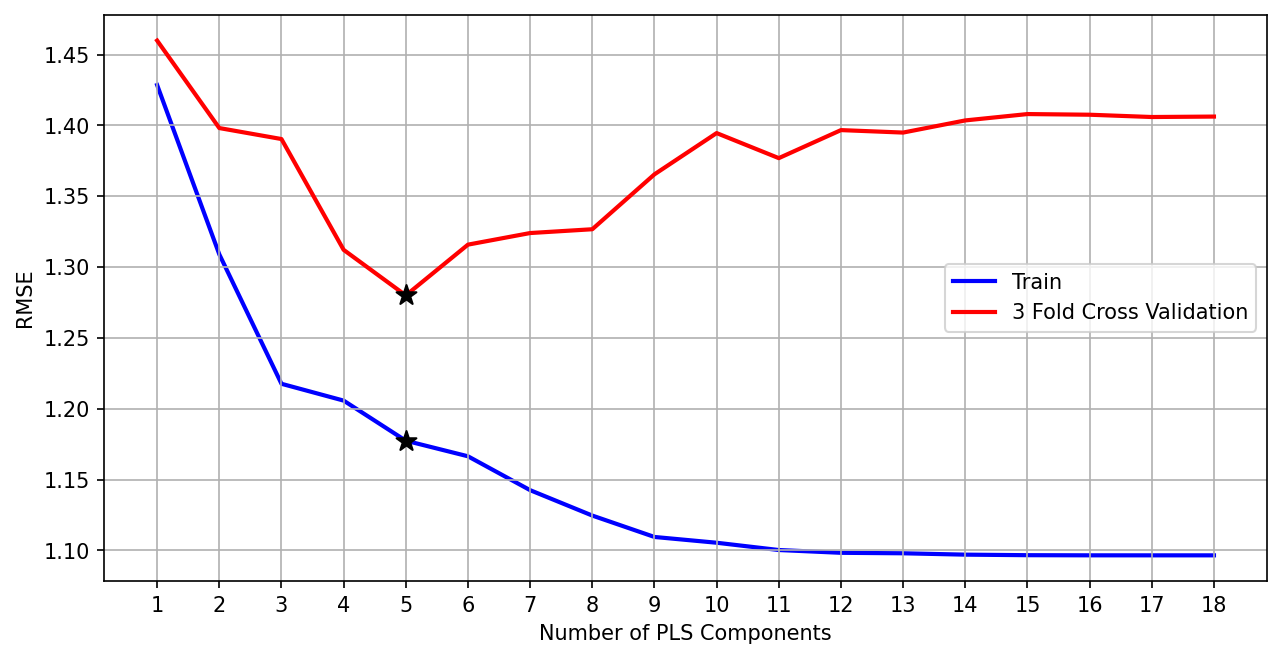

In [28]:
# Plot grid search results

plt.figure(figsize=(10, 5), dpi=150)

components = np.arange(1, X.shape[1]+1, 1)
plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[4], train_rmse[4], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[4], cv_rmse[4], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PLS Components")
plt.ylabel("RMSE")

plt.legend(loc='center right')
plt.grid()
plt.show()

In [29]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = PLSRegression(n_components=5)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.177428899933704
MAE: 0.9625358282867666
R2 Score: 0.4735973525391314

VALIDATION: -
RMSE: 1.2800160512031544, Standard Deviation: 0.4196544928523808
MAE: 1.009097799207824, Standard Deviation: 0.11696824932541623
R2 Score: 0.34313660277591046, Standard Deviation: 0.12790341470256628


Residual Analysis

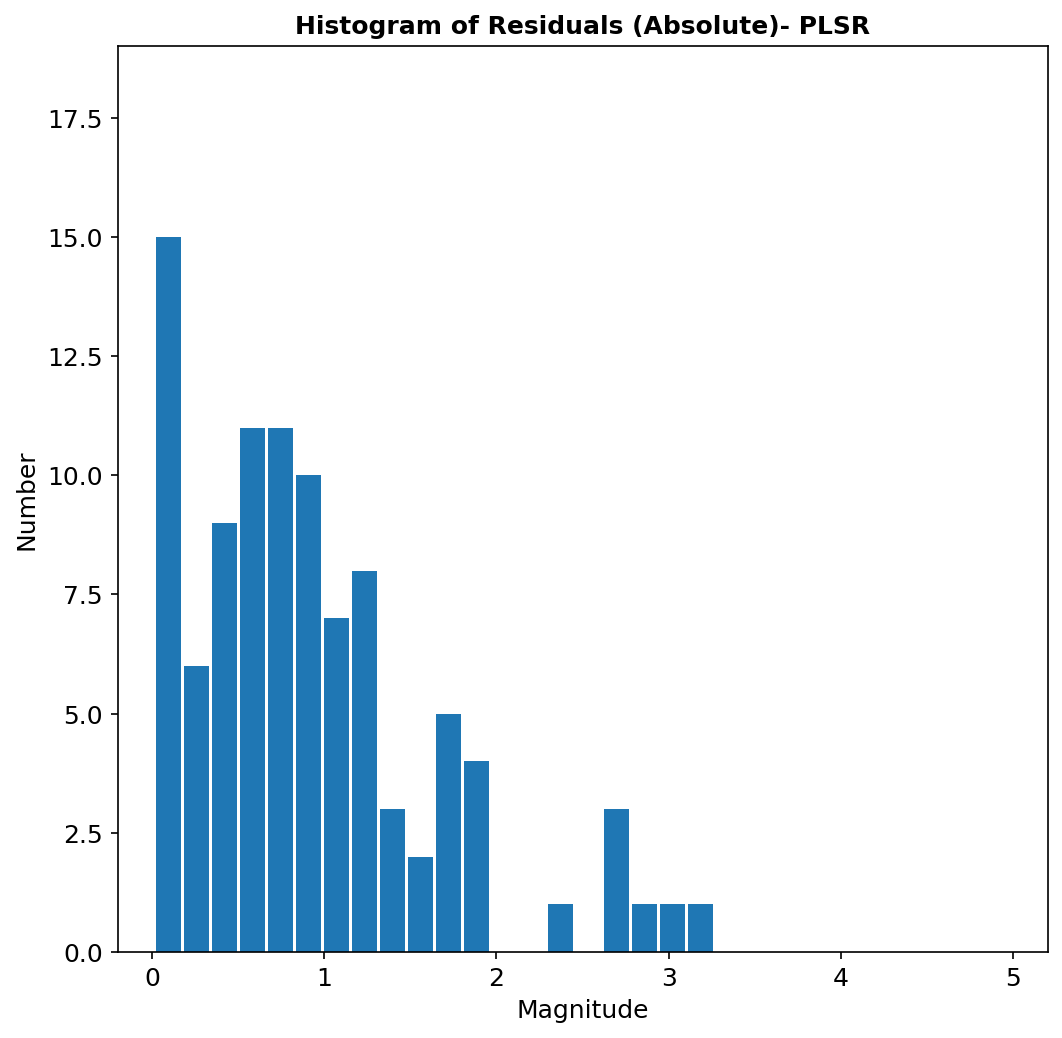

In [33]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- PLSR", fontsize=12, fontweight='bold')
plt.show()

### PCR

In [21]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, X.shape[1]+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, X.shape[1]+1):

    regressor = PCR(n_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

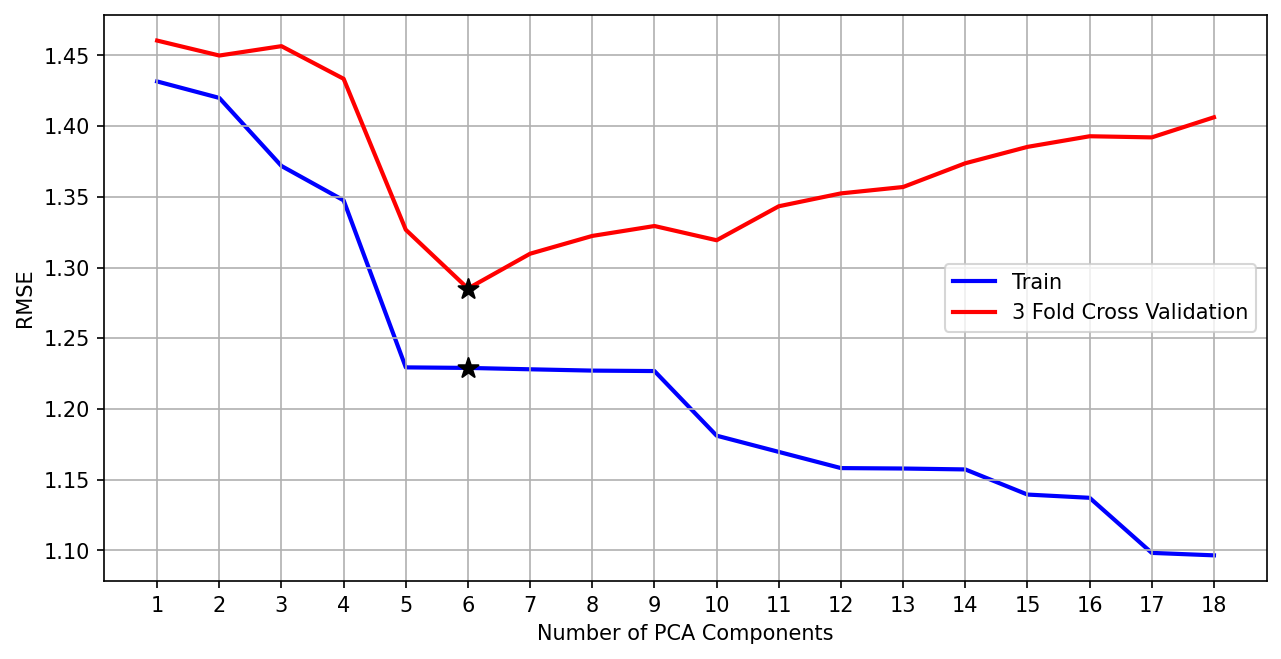

In [22]:
# Plot grid search results

plt.figure(figsize=(10, 5), dpi=150)

components = np.arange(1, X.shape[1]+1, 1)
plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[5], train_rmse[5], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[5], cv_rmse[5], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PCA Components")
plt.ylabel("RMSE")

plt.legend(loc='center right')
plt.grid()
plt.show()

In [34]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = PCR(n_components=6)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.229028116117011
MAE: 0.9853428046098719
R2 Score: 0.42644863378973763

VALIDATION: -
RMSE: 1.2851750266014421, Standard Deviation: 0.38756526103389466
MAE: 1.0068257940960412, Standard Deviation: 0.1333342444692867
R2 Score: 0.3388587146695384, Standard Deviation: 0.11299397961321123


Residual Analysis

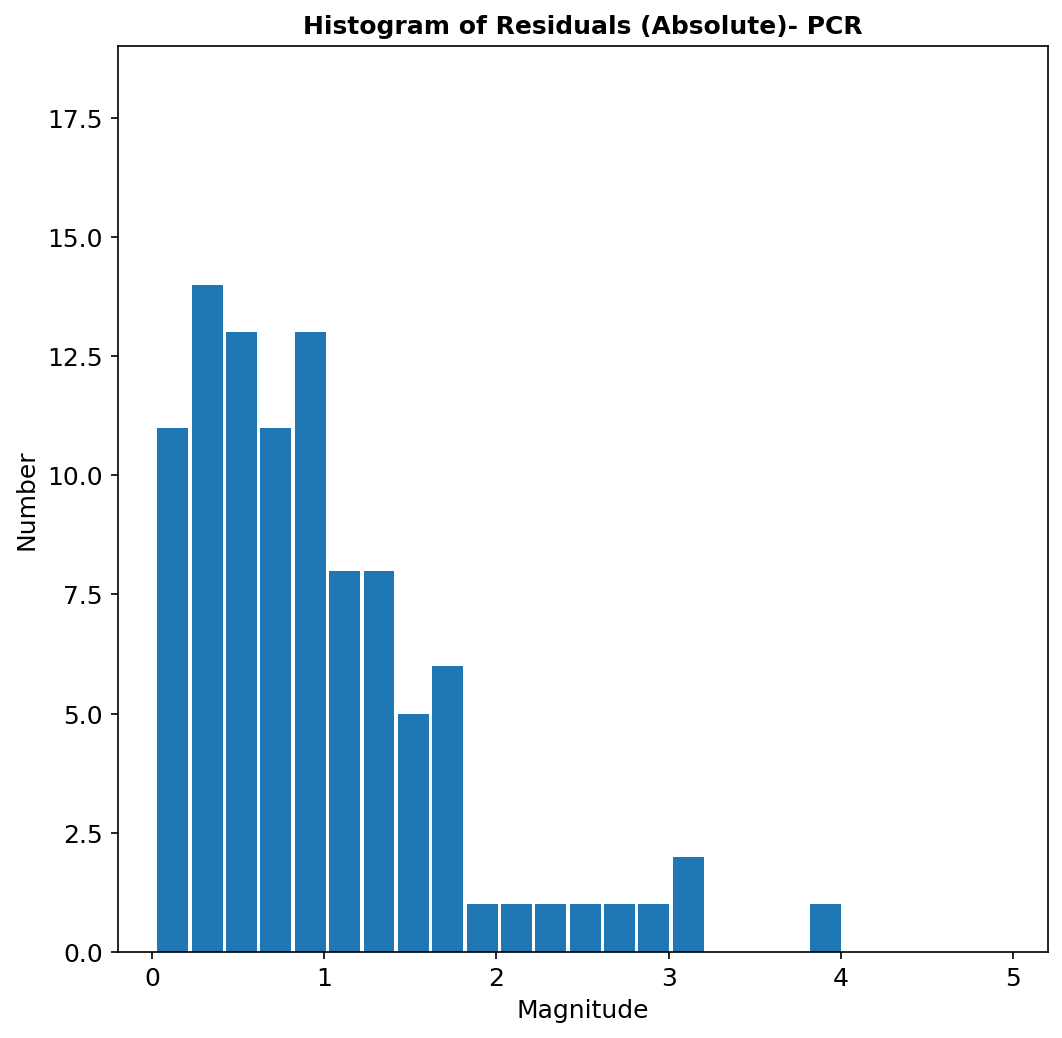

In [35]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- PCR", fontsize=12, fontweight='bold')
plt.show()

### SPCA LR

In [34]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

n_fs = np.arange(1, 18+1)

model_rmse = []

for n in n_fs:
    n_rmse = []
    for a in range(1, n+1):
        m = SPCA_LR(top_n=n, pca_components=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        n_rmse.append(np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"])))
    
    model_rmse.append(n_rmse)

In [22]:
min_n_rmse = [min(model_rmse[i]) for i in range(len(model_rmse))]

top_n = np.argmin(min_n_rmse)+1

pca_components = np.argmin(model_rmse[top_n-1])+1

(top_n, pca_components)

(14, 5)

In [24]:
# Grid Search 2 - Redundant - Plotting purpose

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, 14+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, 14+1):

    regressor = SPCA_LR(top_n=14, pca_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

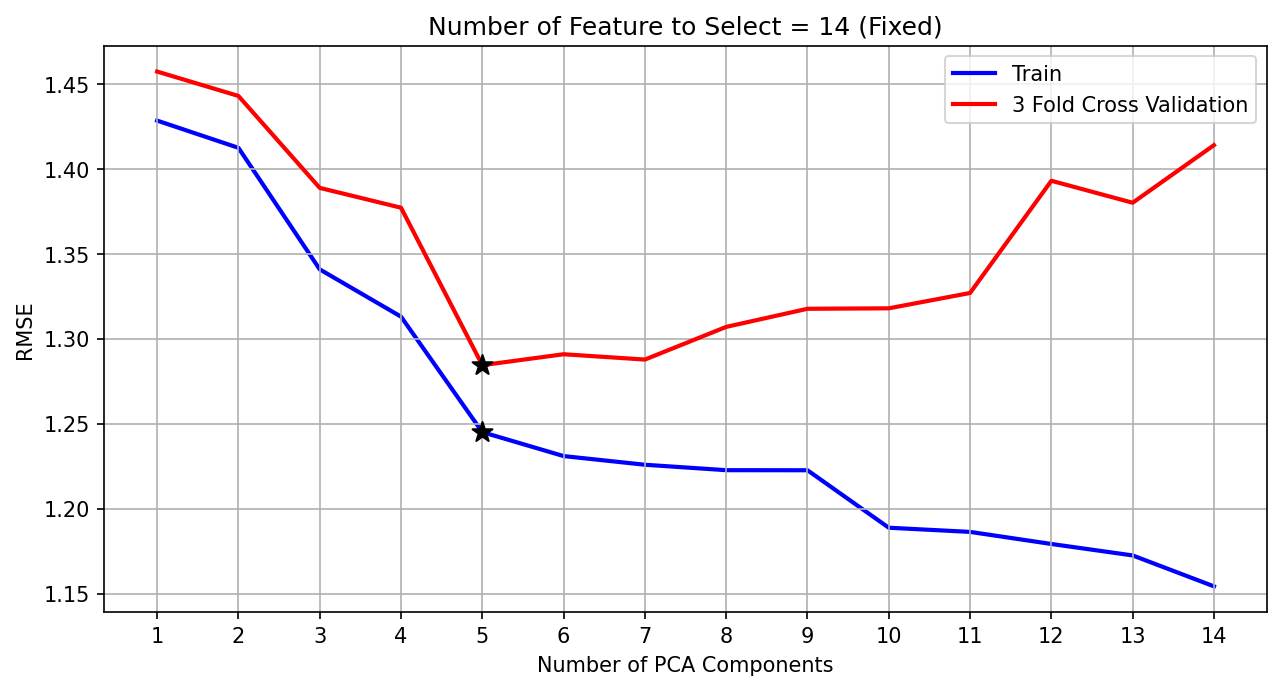

In [31]:
# Plot grid search 2 results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[4], train_rmse[4], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[4], cv_rmse[4], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PCA Components")
plt.ylabel("RMSE")
plt.title("Number of Feature to Select = 14 (Fixed)")

plt.legend(loc='upper right')
plt.grid()
plt.show()

In [27]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = SPCA_LR(top_n=top_n, pca_components=pca_components)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.2450412669716628
MAE: 0.996033573487292
R2 Score: 0.41140553346039244

VALIDATION: -
RMSE: 1.2844680860787203, Standard Deviation: 0.3222895189909266
MAE: 1.0267203375146896, Standard Deviation: 0.1197655605004585
R2 Score: 0.33128197531276465, Standard Deviation: 0.13120880473679616


Residual Analysis

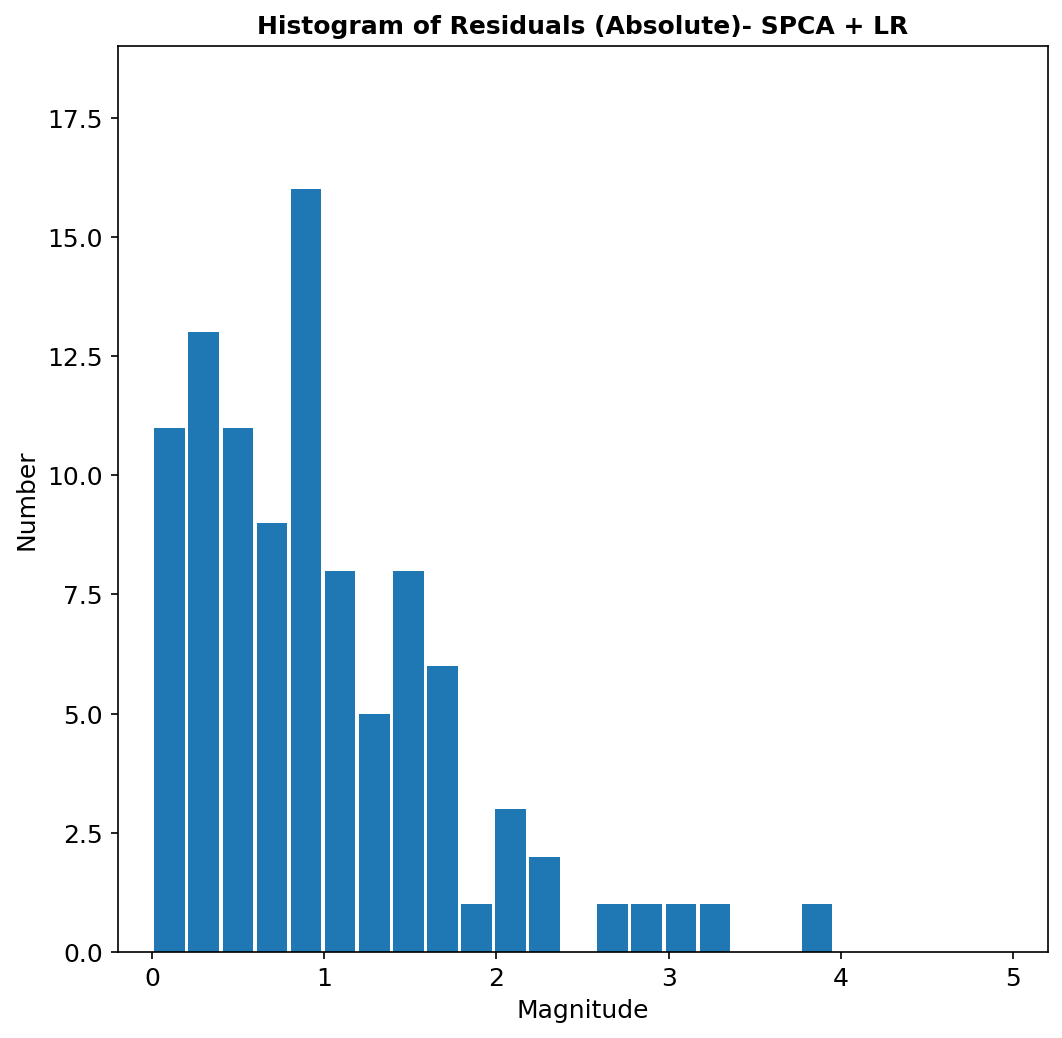

In [32]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- SPCA + LR", fontsize=12, fontweight='bold')
plt.show()